In [6]:
import pandas as pd
import json
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [7]:
from src import experiment_utils as eu

In [8]:
mdb_files, splitter = eu.create_splits()

In [9]:
split = {}
for i, (train, test) in enumerate(splitter):
    train_tracks = mdb_files[train]
    test_tracks = mdb_files[test]
    split[i+1] = {'train': [str(t) for t in train_tracks], 'test': [str(t) for t in test_tracks]}
    
    
with open('test_data/experiment_splits.json', 'w') as fhandle:
    json.dump(split, fhandle, indent=2)

In [11]:
with open('test_data/experiment_splits.json', 'r') as fhandle:
    splits = json.load(fhandle)

In [12]:
opt_nu = pd.DataFrame(index=splits.keys(), columns=['melody1', 'melody2'])

for split in splits.keys():
    train = [str(t) for t in splits[split]['train']]
    test = splits[split]['test']
    
    mel1_scores = glob.glob("melodia_scores/melody1/*.json")
    nu_vals = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1.5, -1, -0.5, 
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    split_summary_mel1 = pd.DataFrame(columns=nu_vals)
    split_summary_mel1_test = pd.DataFrame(columns=nu_vals)
    
    for nu_scores in mel1_scores:
        df1 = pd.io.json.read_json(nu_scores, orient='index')
        nu = os.path.basename(nu_scores).split('_')[1]
        if nu[0] == 'n':
            if len(nu[1:]) == 3:
                nu = -int(nu[1:])/10.0
            else:
                nu = -int(nu[1:])
        else:
            nu = int(nu)
        
        split_summary_mel1.loc[:, nu] = df1.loc[train, :].mean()
        split_summary_mel1_test.loc[:, nu] = df1.loc[test, :].mean()
        
    mel2_scores = glob.glob("melodia_scores/melody2/*.json")
    nu_vals = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1.5, -1, -0.5, 
               0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    split_summary_mel2 = pd.DataFrame(columns=nu_vals)
    split_summary_mel2_test = pd.DataFrame(columns=nu_vals)
    
    for nu_scores in mel2_scores:
        df2 = pd.io.json.read_json(nu_scores, orient='index')
        nu = os.path.basename(nu_scores).split('_')[1]
        if nu[0] == 'n':
            if len(nu[1:]) == 3:
                nu = -int(nu[1:])/10.0
            else:
                nu = -int(nu[1:])
        else:
            nu = int(nu)
        split_summary_mel2.loc[:, nu] = df2.loc[train, :].mean()
        split_summary_mel2_test.loc[:, nu] = df2.loc[test, :].mean()
    
    plt.plot(split_summary_mel1.columns, split_summary_mel1.loc['Overall Accuracy', :], label='melody1 train')
    plt.plot(split_summary_mel1_test.columns, split_summary_mel1_test.loc['Overall Accuracy', :], '--', label='melody1 test')
    plt.plot(split_summary_mel2.columns, split_summary_mel2.loc['Overall Accuracy', :], label='melody2 train')
    plt.plot(split_summary_mel2_test.columns, split_summary_mel2_test.loc['Overall Accuracy', :], '--', label='melody2 test')
    plt.legend()
    plt.title('Split number %s' % split)
    plt.show()
    
    opt_nu.loc[split, 'melody1'] = split_summary_mel1.loc['Overall Accuracy', :].idxmax(axis=1)
    opt_nu.loc[split, 'melody2'] = split_summary_mel2.loc['Overall Accuracy', :].idxmax(axis=1)
opt_nu

KeyError: 'the label [Overall Accuracy] is not in the [index]'

In [8]:
split_summary_mel1.loc['Overall Accuracy', :].idxmax(axis=1)

-1.5

In [8]:
opt_nu

,melody1,melody2
1,-1.5,-0.5
3,-1.5,-0.5
2,-1.5,-0.5
5,-1.5,-1
4,-1.5,-0.5


In [42]:
OA = pd.DataFrame(index=splits.keys(), columns=['oa_mu1', 'oa_sig1', 'oa_mu2', 'oa_sig2'])
RFA = pd.DataFrame(index=splits.keys(), columns=['vr_mu1', 'vr_sig1', 'vr_mu2', 'vr_sig2',\
                                                 'vfa_mu1', 'vfa_sig1', 'vfa_mu2', 'vfa_sig2'])
PC = pd.DataFrame(index=splits.keys(), columns=['rp_mu1', 'rp_sig1', 'rp_mu2', 'rp_sig2',\
                                                 'rc_mu1', 'rc_sig1', 'rc_mu2', 'rc_sig2'])
OA_inst = pd.DataFrame(index=splits.keys(), columns=['oa_mu1', 'oa_sig1', 'oa_mu2', 'oa_sig2'])
OA_voc = pd.DataFrame(index=splits.keys(), columns=['oa_mu1', 'oa_sig1', 'oa_mu2', 'oa_sig2'])

with open("v_i_splits.json", 'r') as fhandle:
    vi_dict = json.load(fhandle)

inst = [k for k in vi_dict.keys() if vi_dict[k] == "i"]
voc = [k for k in vi_dict.keys() if vi_dict[k] == "v"]

for split in splits.keys():
    test = splits[split]['test']
    
    nu = opt_nu.loc[split, 'melody1']
    if nu == -1.5:
        nu_str = 'n015'
    elif nu == -0.5:
        nu_str = 'n005'
    else:
        nu_str = 'n005'
    df1 = pd.io.json.read_json("melodia_scores/melody1/nu_%s_melody1.json" % nu_str, orient='index')
    df1 = df1.loc[test, :]
    OA.loc[split, 'oa_mu1'] = df1['Overall Accuracy'].mean()
    OA.loc[split, 'oa_sig1'] = df1['Overall Accuracy'].std()
    RFA.loc[split, 'vr_mu1'] = df1['Voicing Recall'].mean()
    RFA.loc[split, 'vr_sig1'] = df1['Voicing Recall'].std()
    RFA.loc[split, 'vfa_mu1'] = df1['Voicing False Alarm'].mean()
    RFA.loc[split, 'vfa_sig1'] = df1['Voicing False Alarm'].std()
    PC.loc[split, 'rp_mu1'] = df1['Raw Pitch Accuracy'].mean()
    PC.loc[split, 'rp_sig1'] = df1['Raw Pitch Accuracy'].std()
    PC.loc[split, 'rc_mu1'] = df1['Raw Chroma Accuracy'].mean()
    PC.loc[split, 'rc_sig1'] = df1['Raw Chroma Accuracy'].std()
    
    OA_inst.loc[split, 'oa_mu1'] = df1.loc[inst, 'Overall Accuracy'].mean()
    OA_inst.loc[split, 'oa_sig1'] = df1.loc[inst, 'Overall Accuracy'].std()
    OA_voc.loc[split, 'oa_mu1'] = df1.loc[voc, 'Overall Accuracy'].mean()
    OA_voc.loc[split, 'oa_sig1'] = df1.loc[voc, 'Overall Accuracy'].std()
    
    nu = opt_nu.loc[split, 'melody2']
    if nu == -1.5:
        nu_str = 'n015'
    elif nu == -0.5:
        nu_str = 'n005'
    else:
        nu_str = 'n005'    
    df2 = pd.io.json.read_json("melodia_scores/melody2/nu_%s_melody2.json" % nu_str, orient='index')
    df2 = df2.loc[test, :]
    OA.loc[split, 'oa_mu2'] = df2['Overall Accuracy'].mean()
    OA.loc[split, 'oa_sig2'] = df2['Overall Accuracy'].std()
    RFA.loc[split, 'vr_mu2'] = df2['Voicing Recall'].mean()
    RFA.loc[split, 'vr_sig2'] = df2['Voicing Recall'].std()
    RFA.loc[split, 'vfa_mu2'] = df2['Voicing False Alarm'].mean()
    RFA.loc[split, 'vfa_sig2'] = df2['Voicing False Alarm'].std()
    PC.loc[split, 'rp_mu2'] = df2['Raw Pitch Accuracy'].mean()
    PC.loc[split, 'rp_sig2'] = df2['Raw Pitch Accuracy'].std()
    PC.loc[split, 'rc_mu2'] = df2['Raw Chroma Accuracy'].mean()
    PC.loc[split, 'rc_sig2'] = df2['Raw Chroma Accuracy'].std()
    
    OA_inst.loc[split, 'oa_mu2'] = df2.loc[inst, 'Overall Accuracy'].mean()
    OA_inst.loc[split, 'oa_sig2'] = df2.loc[inst, 'Overall Accuracy'].std()
    OA_voc.loc[split, 'oa_mu2'] = df2.loc[voc, 'Overall Accuracy'].mean()
    OA_voc.loc[split, 'oa_sig2'] = df2.loc[voc, 'Overall Accuracy'].std()
    
    OA.sort_index(inplace=True)
    RFA.sort_index(inplace=True)
    PC.sort_index(inplace=True)

In [43]:
OA_inst

,oa_mu1,oa_sig1,oa_mu2,oa_sig2
1,0.4611308,0.1979423,0.439134,0.154582
3,0.4309163,0.1898921,0.462058,0.1691504
2,0.4577948,0.2024942,0.3778529,0.1897983
5,0.4140301,0.1290595,0.5153651,0.08567236
4,0.3858988,0.1546838,0.3838139,0.1019325


In [30]:
PC.mean()

rp_mu1     0.491225
rp_sig1    0.239246
rp_mu2     0.536113
rp_sig2    0.210671
rc_mu1     0.679087
rc_sig1    0.177725
rc_mu2     0.675143
rc_sig2    0.148651
dtype: float64

In [27]:
meltype=1

In [25]:
if meltype==1:
    olap=0.4
else:
    olap=0.5
    
olap_dir = "olap_%s" % olap
mel_dir = "/Users/rachelbittner/Desktop/exper_output/ver1/CC_exper_mel%s" % meltype
melscore_dat = {}
melscore_var = {}

for split in range(1, 6):
    split_dir = "splitnum_%s" % split
    temp_path = os.path.join(mel_dir, split_dir, olap_dir)
    
    mel_score_fpath = os.path.join(temp_path, "mel_score_summary.csv")
    temp_df = pd.read_csv(mel_score_fpath, index_col=0)
    melscore_dat[split] = temp_df.iloc[1, :].convert_objects(convert_numeric=True)
    melscore_var[split] = temp_df.iloc[2, :].convert_objects(convert_numeric=True)

melmeans = pd.concat(melscore_dat, axis=1)
melstd = pd.concat(melscore_var, axis=1)
melscore_dict_avg = pd.concat(melscore_dat).groupby(level=0).mean()
melscore_dict_std = pd.concat(melscore_dat).groupby(level=0).std()


In [21]:
melmeans.mean(axis=1)

VR     0.773424
VFA    0.466247
RPA    0.505600
RCA    0.600497
OA     0.507091
dtype: float64

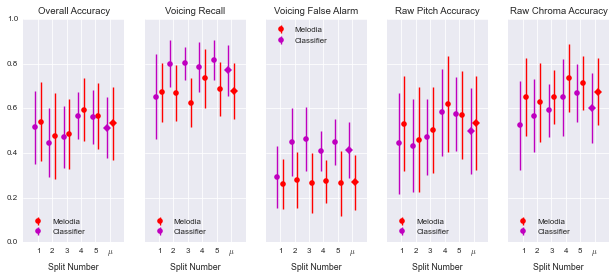

In [141]:
fig = plt.figure(figsize=(10.5,4))

plt.subplot(1, 5, 1)
xvals = np.array([int(i) for i in OA.index])
plt.errorbar(xvals+0.2, OA['oa_mu%s'% meltype], yerr=OA['oa_sig%s' % meltype], fmt='o', color='red', label='Melodia', capsize=0)
plt.errorbar(xvals-0.2, melmeans.loc['OA', :], yerr=melstd.loc['OA', :], fmt='o', color='m', label='Classifier', capsize=0)
plt.errorbar(6+0.2, OA['oa_mu%s'% meltype].mean(), OA['oa_sig%s'% meltype].mean(), fmt='D', color='red', capsize=0)
plt.errorbar(6-0.2, melmeans.loc['OA', :].mean(), melstd.loc['OA', :].mean(), fmt='D', color='m', capsize=0)
plt.legend(loc=3)
plt.xlim([0, 7])
plt.ylim([0, 1])
plt.xticks([1,2,3,4,5,6], ('1','2','3','4','5','$\mu$'))
plt.xlabel('Split Number')
plt.title('Overall Accuracy')

plt.subplot(1, 5, 2)
xvals = np.array([int(i) for i in RFA.index])
plt.errorbar(xvals+0.2, RFA['vr_mu%s'% meltype], yerr=RFA['vr_sig%s'% meltype], fmt='o', color='red', label='Melodia', capsize=0)
plt.errorbar(xvals-0.2, melmeans.loc['VR', :], yerr=melstd.loc['VR', :], fmt='o', color='m', label='Classifier', capsize=0)
plt.errorbar(6+0.2, RFA['vr_mu%s'% meltype].mean(), RFA['vr_sig%s'% meltype].mean(), fmt='D', color='red', capsize=0)
plt.errorbar(6-0.2, melmeans.loc['VR', :].mean(), melstd.loc['VR', :].mean(), fmt='D', color='m', capsize=0)
plt.legend(loc=3)
plt.xlim([0, 7])
plt.ylim([0, 1])
plt.xticks([1,2,3,4,5,6], ('1','2','3','4','5','$\mu$'))
plt.tick_params(axis='y', which='both', bottom='off', top='off', labelleft='off' )
plt.xlabel('Split Number')
plt.title('Voicing Recall')

plt.subplot(1, 5, 3)
xvals = np.array([int(i) for i in RFA.index])
plt.errorbar(xvals+0.2, RFA['vfa_mu%s'% meltype], yerr=RFA['vfa_sig%s'% meltype], fmt='o', color='red', label='Melodia', capsize=0)
plt.errorbar(xvals-0.2, melmeans.loc['VFA', :], yerr=melstd.loc['VFA', :], fmt='o', color='m', label='Classifier', capsize=0)
plt.errorbar(6+0.2, RFA['vfa_mu%s'% meltype].mean(), RFA['vfa_sig%s'% meltype].mean(), fmt='D', color='red', capsize=0)
plt.errorbar(6-0.2, melmeans.loc['VFA', :].mean(), melstd.loc['VFA', :].mean(), fmt='D', color='m', capsize=0)
plt.legend(loc=2)
plt.xlim([0, 7])
plt.ylim([0, 1])
plt.xticks([1,2,3,4,5,6], ('1','2','3','4','5','$\mu$'))
plt.tick_params(axis='y', which='both', bottom='off', top='off', labelleft='off' )
plt.xlabel('Split Number')
plt.title('Voicing False Alarm')

plt.subplot(1, 5, 4)
xvals = np.array([int(i) for i in PC.index])
plt.errorbar(xvals+0.2, PC['rp_mu%s'% meltype], yerr=PC['rp_sig%s'% meltype], fmt='o', color='red', label='Melodia', capsize=0)
plt.errorbar(xvals-0.2, melmeans.loc['RPA', :], yerr=melstd.loc['RPA', :], fmt='o', color='m', label='Classifier', capsize=0)
plt.errorbar(6+0.2, PC['rp_mu%s'% meltype].mean(), PC['rp_sig%s'% meltype].mean(), fmt='D', color='red', capsize=0)
plt.errorbar(6-0.2, melmeans.loc['RPA', :].mean(), melstd.loc['RPA', :].mean(), fmt='D', color='m', capsize=0)
plt.legend(loc=3)
plt.xlim([0, 7])
plt.ylim([0, 1])
plt.xticks([1,2,3,4,5,6], ('1','2','3','4','5','$\mu$'))
plt.tick_params(axis='y', which='both', bottom='off', top='off', labelleft='off' )
plt.xlabel('Split Number')
plt.title('Raw Pitch Accuracy')

plt.subplot(1, 5, 5)
xvals = np.array([int(i) for i in PC.index])
plt.errorbar(xvals+0.2, PC['rc_mu%s'% meltype], yerr=PC['rc_sig%s'% meltype], fmt='o', color='red', label='Melodia', capsize=0)
plt.errorbar(xvals-0.2, melmeans.loc['RCA', :], yerr=melstd.loc['RCA', :], fmt='o', color='m', label='Classifier', capsize=0)
plt.errorbar(6+0.2, PC['rc_mu%s'% meltype].mean(), PC['rc_sig%s'% meltype].mean(), fmt='D', color='red', capsize=0)
plt.errorbar(6-0.2, melmeans.loc['RCA', :].mean(), melstd.loc['RCA', :].mean(), fmt='D', color='m', capsize=0)
plt.legend(loc=3)
plt.xlim([0, 7])
plt.ylim([0, 1])
plt.xticks([1,2,3,4,5,6], ('1','2','3','4','5','$\mu$'))
plt.tick_params(axis='y', which='both', bottom='off', top='off', labelleft='off' )
plt.xlabel('Split Number')
plt.title('Raw Chroma Accuracy')

#fig.suptitle("Melodia vs. Classifier", fontsize=13, y=1.05)
plt.savefig('/Users/rachelbittner/Desktop/melodia_v_clf_mel%s.eps'% meltype, format='eps')


In [28]:
print melmeans.loc['OA', :].mean()
print OA['oa_mu%s'% meltype].mean()

0.5121178406
0.56025081566


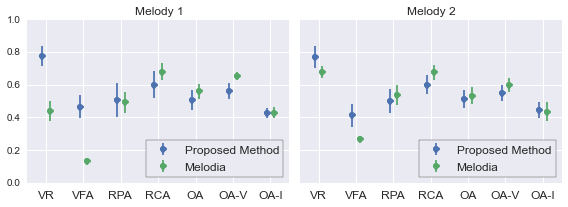

In [66]:
meltype=1
olap=0.4

olap_dir = "olap_%s" % olap
mel_dir = "/Users/rachelbittner/Desktop/exper_output/ver1/CC_exper_mel%s" % meltype
melscore_dat = {}
melscore_var = {}
voc_scores_mean = {}
inst_scores_mean = {}

for split in splits.keys():
    split_dir = "splitnum_%s" % split
    temp_path = os.path.join(mel_dir, split_dir, olap_dir)
    
    mel_score_fpath = os.path.join(temp_path, "mel_score_summary.csv")
    temp_df = pd.read_csv(mel_score_fpath, index_col=0)
    melscore_dat[split] = temp_df.iloc[1, :].convert_objects(convert_numeric=True)
    melscore_var[split] = temp_df.iloc[2, :].convert_objects(convert_numeric=True)
    
    all_mels_fpath = os.path.join(temp_path, "all_mel_scores.csv")
    temp_df = pd.read_csv(all_mels_fpath, index_col=0)
    test = splits[split]['test']
    temp_df = temp_df.loc[test, :]
    voc_scores_mean[split] = temp_df.loc[voc, 'OA'].mean()
    inst_scores_mean[split] = temp_df.loc[inst, 'OA'].mean()
    
melmeans = pd.concat(melscore_dat, axis=1)
melstd = pd.concat(melscore_var, axis=1)
melscore_dict_avg = pd.concat(melscore_dat).groupby(level=0).mean()
melscore_dict_std = pd.concat(melscore_dat).groupby(level=0).std()

c2, c1 = sns.color_palette('deep', 2)

fig = plt.figure(figsize=(8,3))

plt.subplot(1,2,1)

plt.errorbar(7-0.1, np.mean(inst_scores_mean.values()), np.std(inst_scores_mean.values()), fmt='o', color=c2, capsize=0)
plt.errorbar(7+0.1, OA_inst['oa_mu%s' % meltype].mean(), OA_inst['oa_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)

plt.errorbar(6-0.1, np.mean(voc_scores_mean.values()), np.std(voc_scores_mean.values()), fmt='o', color=c2, capsize=0)
plt.errorbar(6+0.1, OA_voc['oa_mu%s' % meltype].mean(), OA_voc['oa_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)

plt.errorbar(5-0.1, melmeans.loc['OA', :].mean(), melmeans.loc['OA', :].std(), fmt='o', color=c2, capsize=0, label="Proposed Method")
plt.errorbar(5+0.1, OA['oa_mu%s' % meltype].mean(), OA['oa_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0, label="Melodia")

plt.errorbar(1+0.1, RFA['vr_mu%s' % meltype].mean(), RFA['vr_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(1-0.1, melmeans.loc['VR', :].mean(), melmeans.loc['VR', :].std(), fmt='o', color=c2, capsize=0)

plt.errorbar(2+0.1, RFA['vfa_mu%s' % meltype].mean(), RFA['vfa_mu%s'  % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(2-0.1, melmeans.loc['VFA', :].mean(), melmeans.loc['VFA', :].std(), fmt='o', color=c2, capsize=0)

plt.errorbar(3+0.1, PC['rp_mu%s' % meltype].mean(), PC['rp_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(3-0.1, melmeans.loc['RPA', :].mean(), melmeans.loc['RPA', :].std(), fmt='o', color=c2, capsize=0)

plt.errorbar(4+0.1, PC['rc_mu%s' % meltype].mean(), PC['rc_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(4-0.1, melmeans.loc['RCA', :].mean(), melmeans.loc['RCA', :].std(), fmt='o', color=c2, capsize=0)

plt.xlim([0.5,7.5])
plt.ylim([0,1])
lgd = plt.legend(loc=4, fontsize=12, frameon=True)
lgd.get_frame().set_edgecolor('k')
plt.title("Melody 1", fontsize=12)
plt.xticks([1,2,3,4,5,6,7], ('VR','VFA','RPA','RCA','OA','OA-V','OA-I'), fontsize=12)

####################
meltype=2
olap=0.5

olap_dir = "olap_%s" % olap
mel_dir = "/Users/rachelbittner/Desktop/exper_output/ver1/CC_exper_mel%s" % meltype
melscore_dat = {}
melscore_var = {}
voc_scores_mean = {}
inst_scores_mean = {}

for split in splits.keys():
    split_dir = "splitnum_%s" % split
    temp_path = os.path.join(mel_dir, split_dir, olap_dir)
    
    mel_score_fpath = os.path.join(temp_path, "mel_score_summary.csv")
    temp_df = pd.read_csv(mel_score_fpath, index_col=0)
    melscore_dat[split] = temp_df.iloc[1, :].convert_objects(convert_numeric=True)
    melscore_var[split] = temp_df.iloc[2, :].convert_objects(convert_numeric=True)
    
    all_mels_fpath = os.path.join(temp_path, "all_mel_scores.csv")
    temp_df = pd.read_csv(all_mels_fpath, index_col=0)
    test = splits[split]['test']
    temp_df = temp_df.loc[test, :]
    voc_scores_mean[split] = temp_df.loc[voc, 'OA'].mean()
    inst_scores_mean[split] = temp_df.loc[inst, 'OA'].mean()

melmeans = pd.concat(melscore_dat, axis=1)
melstd = pd.concat(melscore_var, axis=1)
melscore_dict_avg = pd.concat(melscore_dat).groupby(level=0).mean()
melscore_dict_std = pd.concat(melscore_dat).groupby(level=0).std()

plt.subplot(1,2,2)

plt.errorbar(7-0.1, np.mean(inst_scores_mean.values()), np.std(inst_scores_mean.values()), fmt='o', color=c2, capsize=0)
plt.errorbar(7+0.1, OA_inst['oa_mu%s' % meltype].mean(), OA_inst['oa_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)

plt.errorbar(6-0.1, np.mean(voc_scores_mean.values()), np.std(voc_scores_mean.values()), fmt='o', color=c2, capsize=0)
plt.errorbar(6+0.1, OA_voc['oa_mu%s' % meltype].mean(), OA_voc['oa_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)

plt.errorbar(5-0.1, melmeans.loc['OA', :].mean(), melmeans.loc['OA', :].std(), fmt='o', color=c2, capsize=0, label="Proposed Method")
plt.errorbar(5+0.1, OA['oa_mu%s' % meltype].mean(), OA['oa_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0, label="Melodia")

plt.errorbar(1+0.1, RFA['vr_mu%s' % meltype].mean(), RFA['vr_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(1-0.1, melmeans.loc['VR', :].mean(), melmeans.loc['VR', :].std(), fmt='o', color=c2, capsize=0)

plt.errorbar(2+0.1, RFA['vfa_mu%s' % meltype].mean(), RFA['vfa_mu%s'  % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(2-0.1, melmeans.loc['VFA', :].mean(), melmeans.loc['VFA', :].std(), fmt='o', color=c2, capsize=0)

plt.errorbar(3+0.1, PC['rp_mu%s' % meltype].mean(), PC['rp_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(3-0.1, melmeans.loc['RPA', :].mean(), melmeans.loc['RPA', :].std(), fmt='o', color=c2, capsize=0)

plt.errorbar(4+0.1, PC['rc_mu%s' % meltype].mean(), PC['rc_mu%s' % meltype].std(), fmt='o', color=c1, capsize=0)
plt.errorbar(4-0.1, melmeans.loc['RCA', :].mean(), melmeans.loc['RCA', :].std(), fmt='o', color=c2, capsize=0)

plt.xlim([0.5,7.5])
plt.ylim([0,1])
lgd = plt.legend(loc=4, fontsize=12, frameon=True)
lgd.get_frame().set_edgecolor('k')
plt.title('Melody 2', fontsize=12)
plt.xticks([1,2,3,4,5,6,7], ('VR','VFA','RPA','RCA','OA','OA-V','OA-I'), fontsize=12)
plt.tick_params(axis='y', which='both', bottom='off', top='off', labelleft='off')
fig.tight_layout()

plt.savefig('/Users/rachelbittner/Desktop/melodia_v_clf.eps', format='eps')

In [1]:
melmeans

NameError: name 'melmeans' is not defined